Uniform in x, y - mixture of sech^2 in z


In [1]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import minimize
import corner
from tqdm.auto import tqdm, trange

from gala.units import UnitSystem

from solaroid.coordinates import gal_to_schmagal, schmagal_to_gal
from solaroid.simulate import invt_sample_z
from solaroid.likelihood import Model
from solaroid.density import UniformSech2DensityModel
from solaroid.stats import ln_normal, ln_two_sech2

In [2]:
max_dist = 1.5 * u.kpc
min_b = 30 * u.deg

def S(b, d):
    sim_mask = (
        (np.abs(b) > min_b) &
        (d < max_dist)
    )
    return sim_mask

In [3]:
truth = {
    'h1': 200 * u.pc,
    'h2': 800 * u.pc,
    'f': 0.3,
    'x_sigma': 0.5 * u.kpc,
    'y_sigma': 0.5 * u.kpc,
    'zsun': 174.35 * u.pc,
    'roll': 1. * u.deg,
    'sgrA': coord.SphericalRepresentation(73 * u.deg, -27.4*u.deg, 8.1 * u.kpc)
}

In [4]:
usys = UnitSystem([u.pc, u.rad, u.Msun, u.Myr])

zgrid = np.linspace(-5e3, 5e3, 1024)
rho = np.exp(ln_two_sech2(zgrid, 
                          h1=truth['h1'].value, 
                          h2=truth['h2'].value, 
                          f=truth['f']))

Text(0.5, 0, '$z$ [pc]')

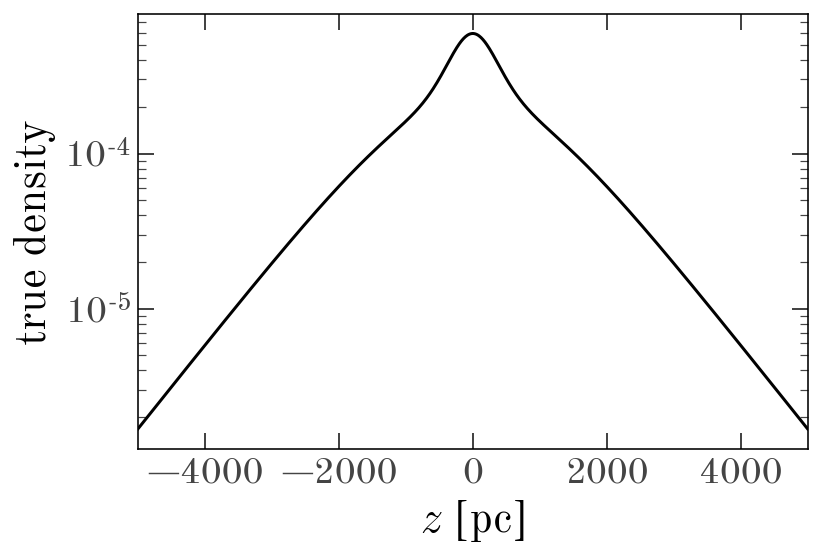

In [5]:
plt.figure(figsize=(6, 4))
plt.plot(zgrid, rho, marker='')

# Approximating with mixture of gaussians...
# shit_z = np.concatenate((
#     np.random.normal(0, 3e2, size=50_000),
#     np.random.normal(0, 1e3, size=100_000),
#     np.random.normal(0, 1.9e3, size=60_000),
# ))
# plt.hist(shit_z, 
#          bins=np.linspace(-5000, 5000, 128), density=True)

plt.xlim(zgrid.min(), zgrid.max())
plt.yscale('log')
plt.ylabel('true density')
plt.xlabel('$z$ [pc]')

In [6]:
N = 4_000_000
truth['ln_n0'] = np.log(N)
rng = np.random.default_rng(seed=42)

args = (truth['h1'].value, truth['h2'].value, truth['f'])
z_samples = invt_sample_z(
    ln_two_sech2,
    args=args, 
    size=N,
    rng=rng,
    grid_size=4096
) * u.pc

# TESTING:
# z_samples = np.concatenate((
#     rng.normal(0, 3e2, size=500_000),
#     rng.normal(0, 1e3, size=1_000_000),
#     rng.normal(0, 1.9e3, size=600_000),
# )) * u.pc
# z_samples = z_samples[rng.choice(len(z_samples), size=N, replace=False)]
# --------

print(np.median(z_samples))
assert np.abs(np.median(z_samples)) < 1 * u.pc

x_args = ((-truth['sgrA'].distance - max_dist).to_value(usys['length']), 
          (-truth['sgrA'].distance + max_dist).to_value(usys['length']))
y_args = ([-1, 1] * max_dist).to_value(usys['length'])
x_samples = rng.uniform(*x_args, size=N) * usys['length']
y_samples = rng.uniform(*y_args, size=N) * usys['length']

# x_samples = rng.normal(
#     -truth['sgrA'].distance.to_value(truth['x_sigma'].unit), 
#     truth['x_sigma'].value, 
#     size=N
# ) * truth['x_sigma'].unit
# y_samples = rng.normal(0, truth['y_sigma'].value, size=N) * truth['y_sigma'].unit

xyz_samples = np.stack((x_samples, y_samples, z_samples), axis=0)
xyz_samples

/Users/apricewhelan/projects/solar-velocity/solaroid/stats.py:13: RuntimeWarning: overflow encountered in cosh
  lnterm1 = np.log(f) - 2 * np.log(np.cosh(x / (2 * h1))) - np.log(4 * h1)
/Users/apricewhelan/projects/solar-velocity/solaroid/stats.py:14: RuntimeWarning: overflow encountered in cosh
  lnterm2 = np.log(1 - f) - 2 * np.log(np.cosh(x / (2 * h2))) - np.log(4 * h2)


-0.5653676075390635 pc


<Quantity [[-7910.78418847, -8961.95721397, -6683.052564  , ...,
            -9453.82032747, -8066.91719339, -7225.7305353 ],
           [ -678.48481954,   -16.56421177,  -441.48998739, ...,
              654.46963405,   493.76254174,  1228.69569549],
           [  648.19427288,  -104.16594229,  1100.82276256, ...,
             1269.94280425,  -606.97556919,   440.91930486]] pc>

(0.0001, 0.001)

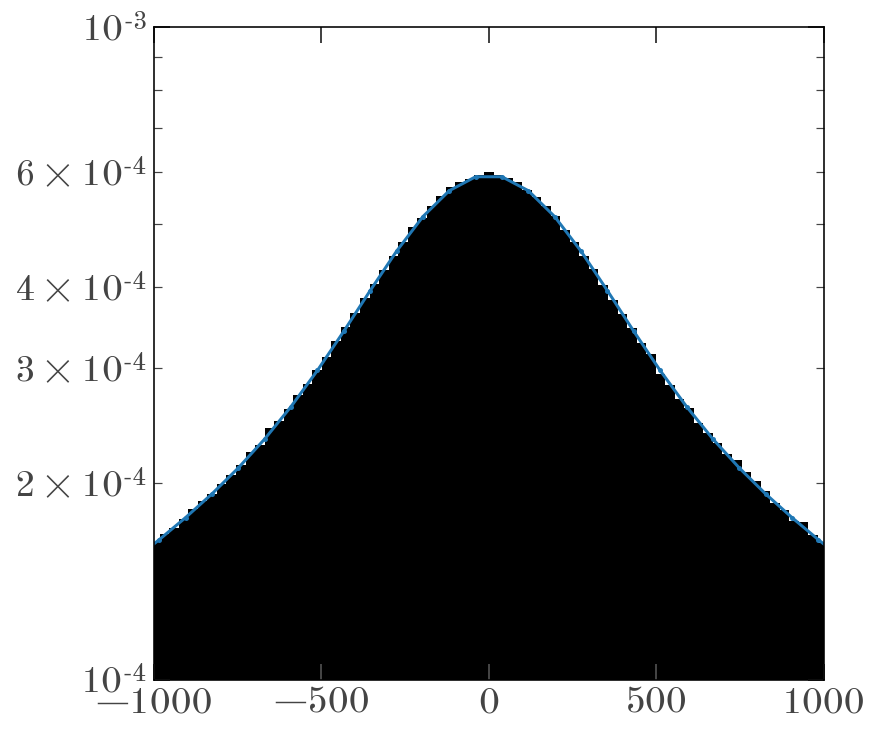

In [7]:
plt.figure(figsize=(6, 6))
plt.hist(z_samples.value, bins=351, density=True);

_zgrid = np.linspace(-5000, 5000, 128)
shit = ln_two_sech2(_zgrid, truth['h1'].value, truth['h2'].value, truth['f'])

plt.plot(_zgrid, np.exp(shit))
plt.yscale('log')
plt.xlim(-1000, 1000)
plt.ylim(1e-4, 1e-3)

In [8]:
sim_schmagal = coord.CartesianRepresentation(xyz_samples)

sim_gal = coord.CartesianRepresentation(
    schmagal_to_gal(xyz_samples, 
                    truth['sgrA'], truth['zsun'], truth['roll'])
)
sim_gal_sph = sim_gal.represent_as(coord.SphericalRepresentation)

In [9]:
sim_mask = S(sim_gal_sph.lat, sim_gal_sph.distance)
sim_mask.sum(), len(sim_mask)

(801933, 4000000)

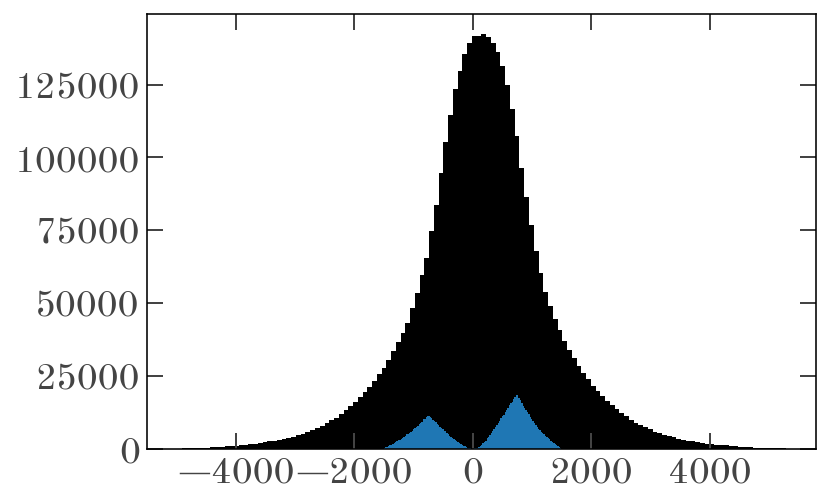

In [10]:
plt.hist(sim_gal.z.value, bins=128);
plt.hist(sim_gal.z.value[sim_mask], bins=128);

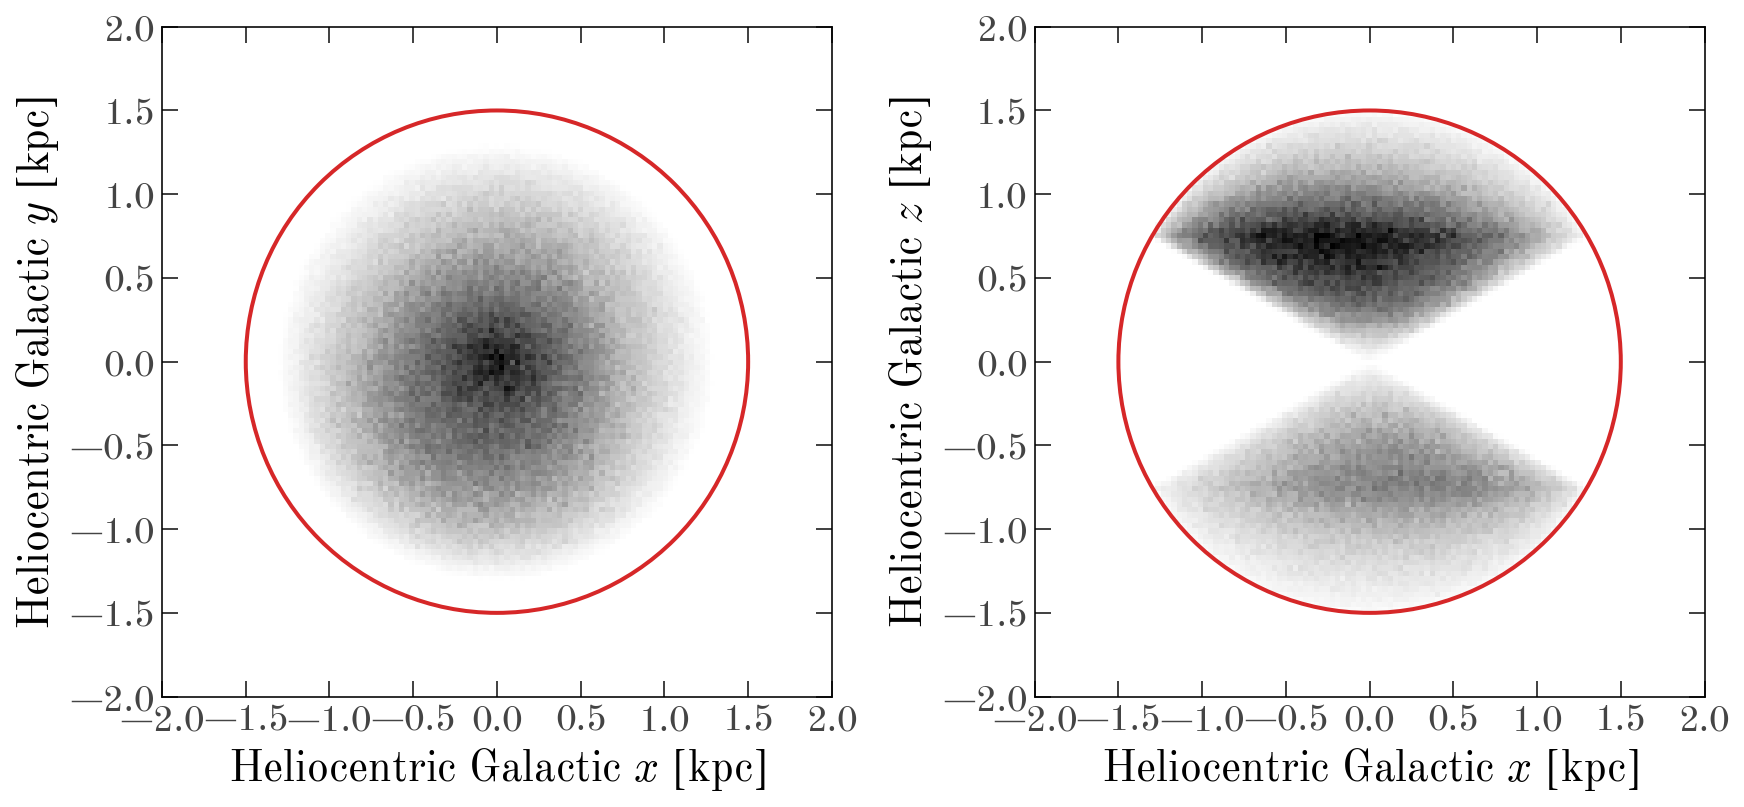

In [11]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(12, 6), 
    constrained_layout=True
)

lim = (-2, 2)
for ax, coords, labels in zip(axes, 
                              [(sim_gal.x[sim_mask].to_value(u.kpc), 
                                sim_gal.y[sim_mask].to_value(u.kpc)), 
                               (sim_gal.x[sim_mask].to_value(u.kpc), 
                                sim_gal.z[sim_mask].to_value(u.kpc))], 
                              [('x', 'y'), ('x', 'z')]):
    ax.hist2d(
        coords[0], 
        coords[1], 
        bins=np.linspace(*lim, 128), 
        cmap='Greys'
    #     norm=mpl.colors.LogNorm()
    )

    circ = mpl.patches.Circle(
        (0, 0),
        radius=max_dist.to_value(u.kpc),
        linewidth=2, 
        facecolor='none',
        edgecolor='tab:red'
    )
    ax.add_patch(circ)
    ax.set_aspect('equal')
    
    ax.set(
        xlabel=f'Heliocentric Galactic ${labels[0]}$ [kpc]',
        ylabel=f'Heliocentric Galactic ${labels[1]}$ [kpc]',
        xlim=lim,
        ylim=lim,
        xticks=np.arange(lim[0], lim[1]+0.1, 0.5),
        yticks=np.arange(lim[0], lim[1]+0.1, 0.5)
    );

In [12]:
data = sim_gal.xyz.decompose(usys)[:, sim_mask]

model_kw = dict(
    DensityModel=UniformSech2DensityModel,
    sgrA_star=truth['sgrA'], 
    min_abs_b=min_b, 
    max_dist=max_dist, 
    usys=usys,
    frozen={
        'x_a': -max_dist,
        'x_b': max_dist,
        'y_a': -max_dist,
        'y_b': max_dist,
    }
)

model = Model(data, **model_kw)
model_all = Model(sim_gal.xyz.decompose(usys), **model_kw)

In [13]:
gal_args = (truth['sgrA'], truth['zsun'], truth['roll'])
z_args = (truth['h1'].value, truth['h2'].value, truth['f'])

density_model = model._get_density_model(truth)
model.ln_integrand(
    0.,
    (31*u.deg).decompose(usys).value,
    (100*u.pc).decompose(usys).value,
    density_model,
    gal_args
)

-14.438871218659306

In [14]:
model.get_ln_Veff(density_model, gal_args)

/Users/apricewhelan/projects/solar-velocity/solaroid/likelihood.py:51: RuntimeWarning: divide by zero encountered in log
  2 * np.log(d) + np.log(np.cos(b))


-1.6117427710534096

/Users/apricewhelan/projects/solar-velocity/solaroid/likelihood.py:51: RuntimeWarning: divide by zero encountered in log
  2 * np.log(d) + np.log(np.cos(b))


-7988648.41460491

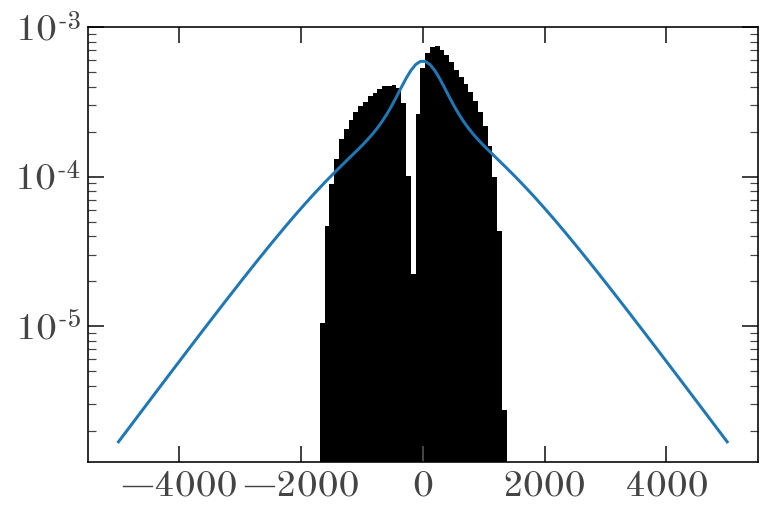

In [17]:
p0 = model.pack_pars(truth)
model.ln_likelihood(p0, plot=True)
# model_all.ln_likelihood(p0, plot=True)

In [18]:
sgrA = truth['sgrA']

all_vals = np.linspace(0.9, 1.1, 16)[None] * np.array(p0)[:, None]

all_lls = []
for i in range(len(p0)):
    print(i)
    this_p0 = np.array(p0, copy=True)
    lls = []
    vals = all_vals[i]
    for j, val in enumerate(vals):
        print(f"{j}/{len(vals)}", end="\r")
        this_p0[i] = val
        lls.append(model.ln_likelihood(this_p0))
    all_lls.append(lls)
all_lls = np.array(all_lls)

0
15/16
25/16
35/16
45/16
55/16


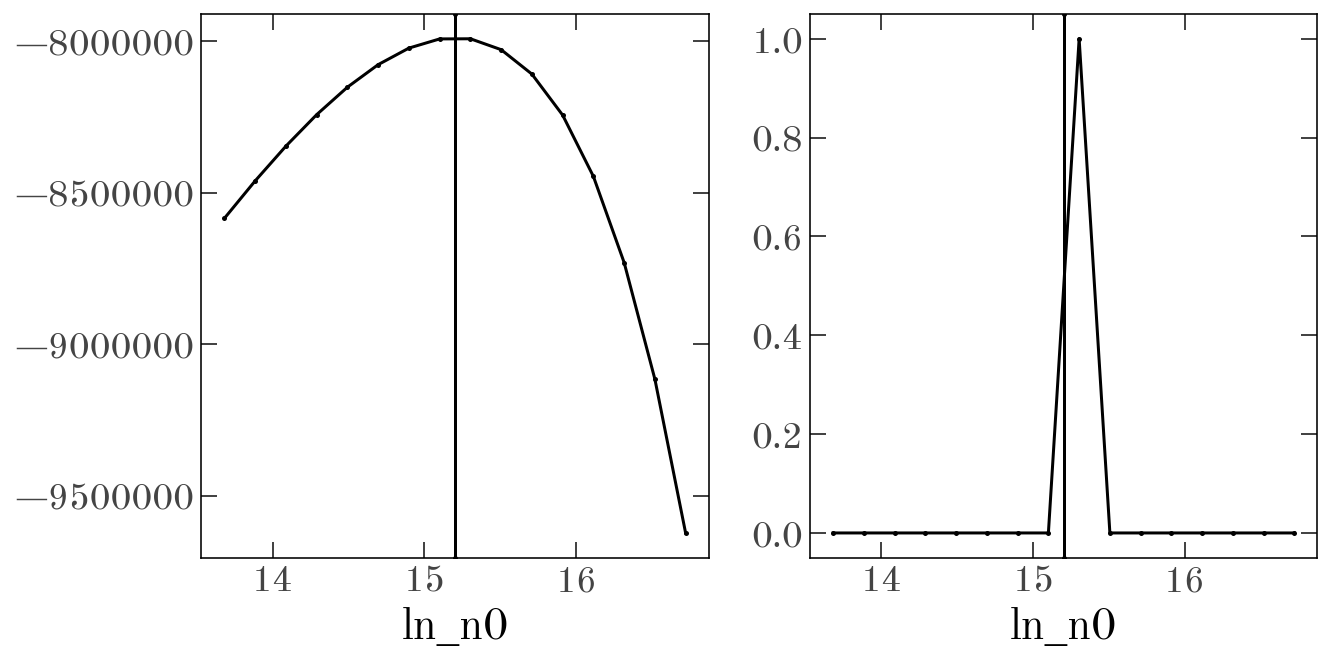

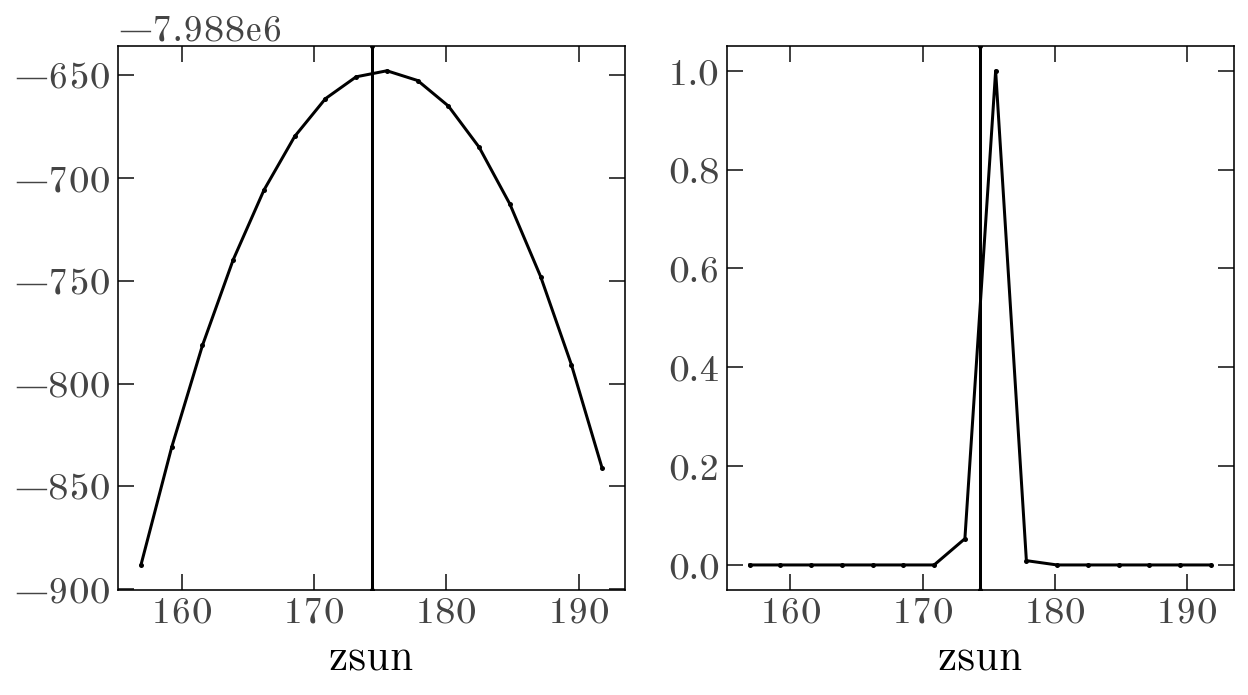

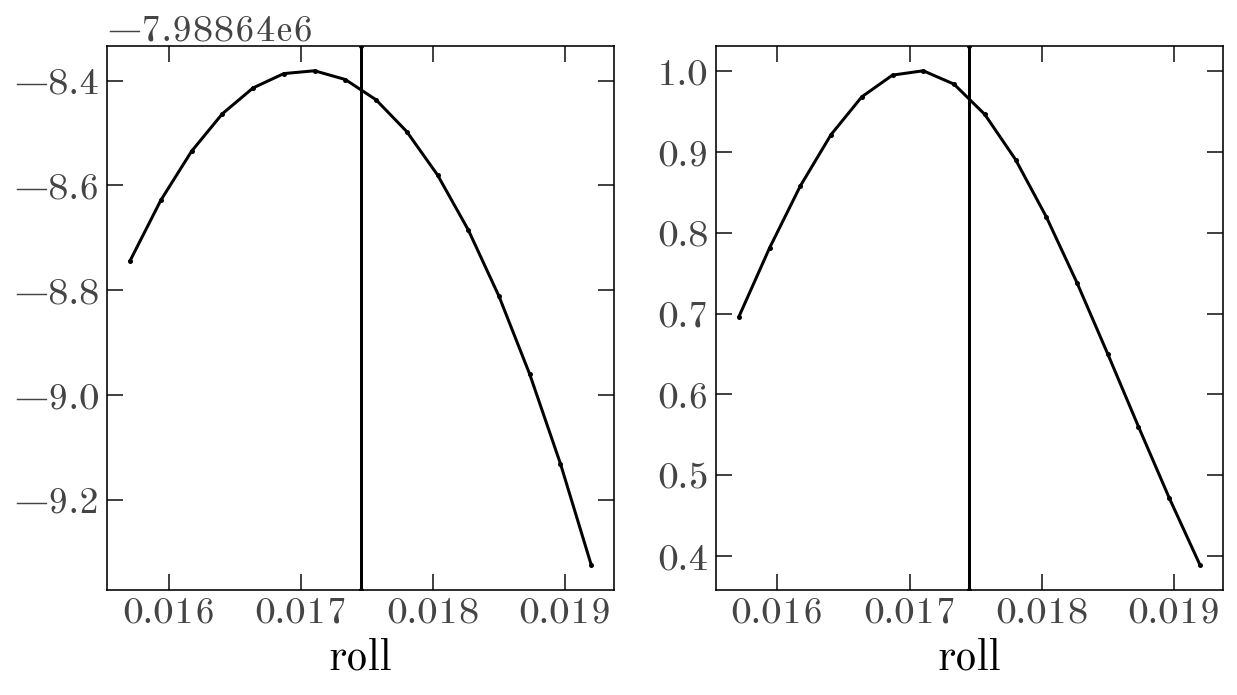

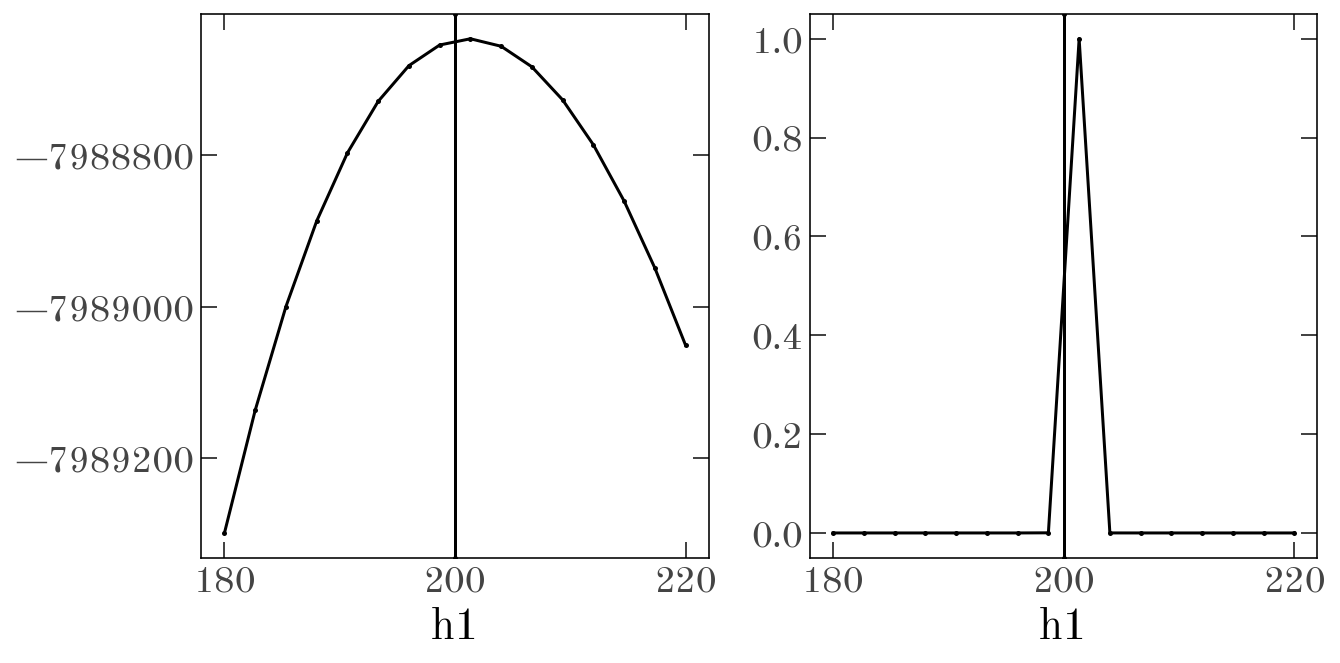

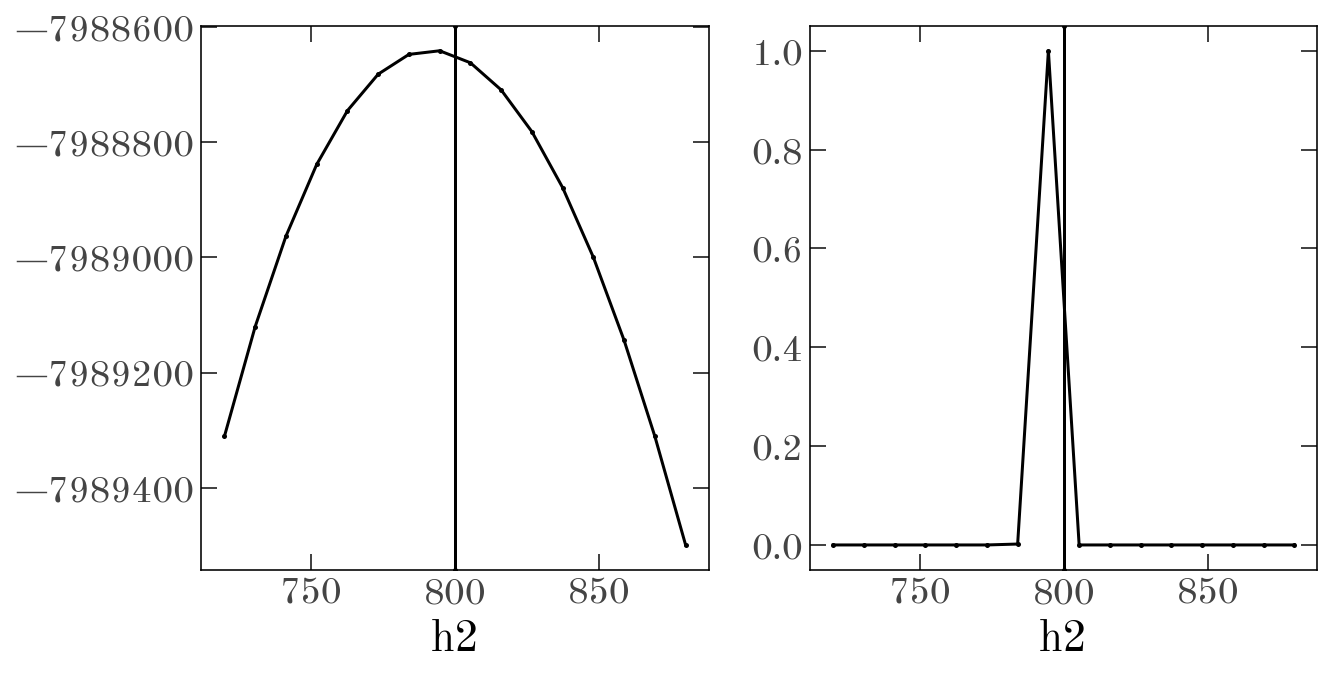

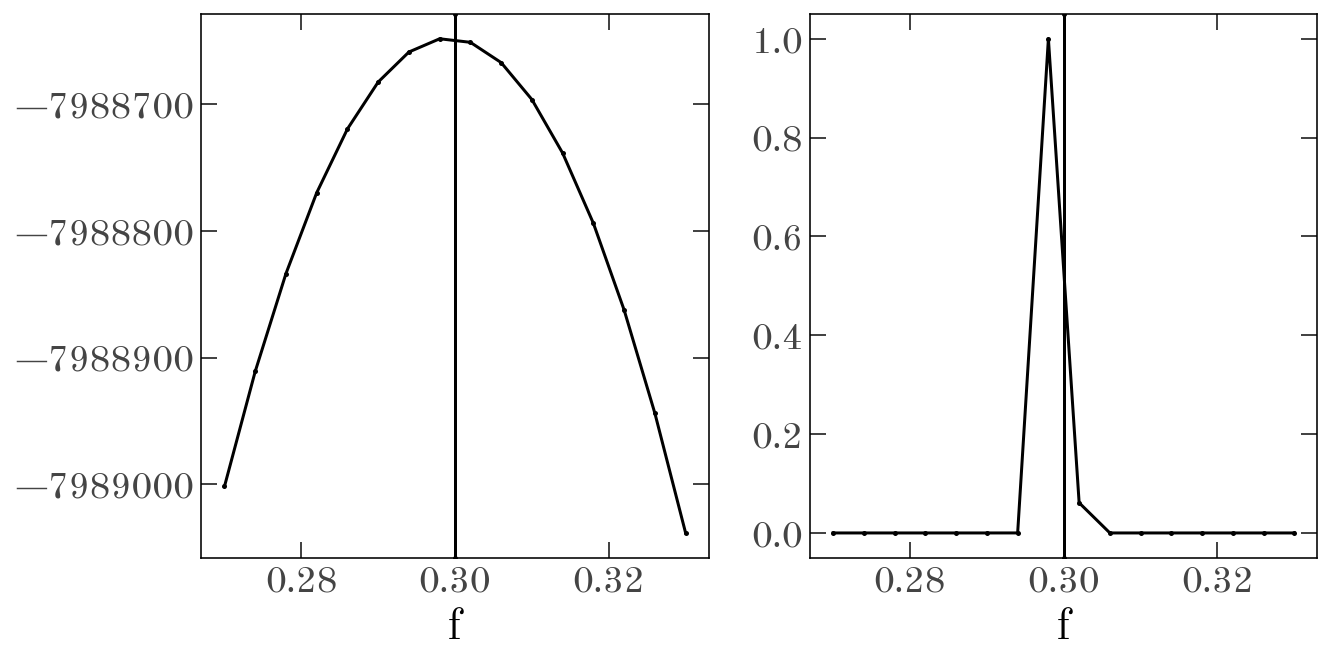

In [19]:
for i in range(all_lls.shape[0]):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(all_vals[i], all_lls[i])
    axes[1].plot(all_vals[i], np.exp(all_lls[i] - all_lls[i].max()))
    for ax in axes:
        ax.set_xlabel(model.par_names[i])
        ax.axvline(p0[i])

In [291]:
full_res = minimize(
    lambda *args: -model.ln_likelihood(*args), 
    x0=p0, 
    method='nelder-mead'
)

/Users/apricewhelan/projects/solar-velocity/solaroid/likelihood.py:48: RuntimeWarning: divide by zero encountered in log
  2 * np.log(d) + np.log(np.cos(b))


In [292]:
np.array(p0)

array([1.52018049e+01, 5.29831737e+00, 6.68461173e+00, 3.00000000e-01,
       1.74350000e+02, 1.74532925e-02])

In [293]:
full_res.x

array([1.51989636e+01, 5.28214356e+00, 6.65945053e+00, 2.92470880e-01,
       1.75099275e+02, 1.68919523e-02])

In [294]:
rng = np.random.default_rng(seed=42)

bootstrap_res = []
for i in range(16):
    print(i, end='\r')
    batch = data[:, rng.choice(data.shape[1], size=data.shape[1])]
    batch_model = Model(batch, truth['sgrA'], min_b, max_dist, usys)
    res = minimize(lambda *args: -batch_model.ln_likelihood(*args), 
                   x0=p0, method='nelder-mead')
    bootstrap_res.append(res)

In [295]:
np.all([res.success for res in bootstrap_res])

True

In [296]:
bootstrap_optp = np.array([res.x for res in bootstrap_res])

TODO: need to create model with different data...

/Users/apricewhelan/projects/solar-velocity/solaroid/likelihood.py:48: RuntimeWarning: divide by zero encountered in log
  2 * np.log(d) + np.log(np.cos(b))
/Users/apricewhelan/projects/solar-velocity/solaroid/likelihood.py:48: RuntimeWarning: divide by zero encountered in log
  2 * np.log(d) + np.log(np.cos(b))
/Users/apricewhelan/projects/solar-velocity/solaroid/likelihood.py:48: RuntimeWarning: divide by zero encountered in log
  2 * np.log(d) + np.log(np.cos(b))


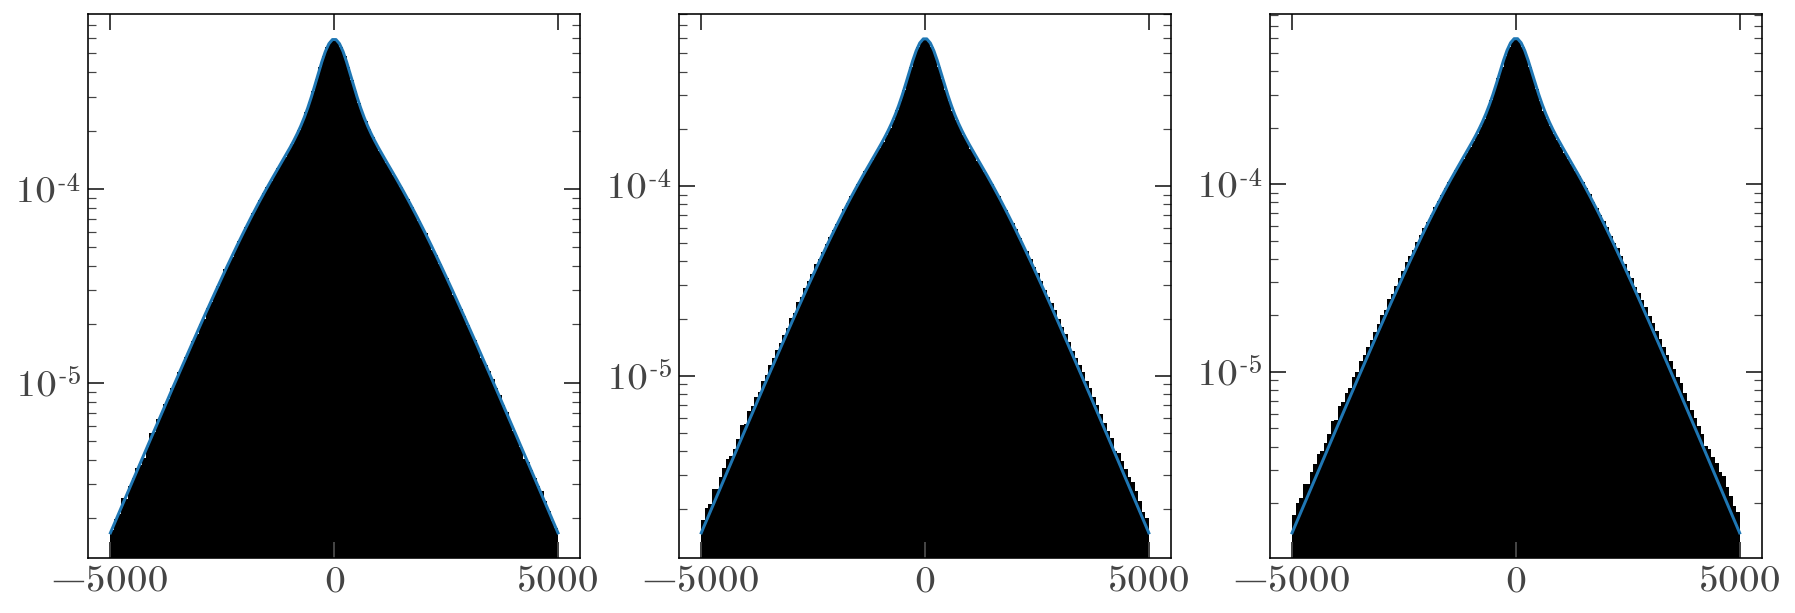

In [297]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
model_all.ln_likelihood(p0, plot=True);

plt.subplot(132)
model_all.ln_likelihood(full_res.x, plot=True);

plt.subplot(133)
model_all.ln_likelihood(bootstrap_optp[0], plot=True);

In [298]:
import corner

In [299]:
np.array(p0)

array([1.52018049e+01, 5.29831737e+00, 6.68461173e+00, 3.00000000e-01,
       1.74350000e+02, 1.74532925e-02])

In [300]:
np.mean(bootstrap_optp, axis=0)

array([1.51995297e+01, 5.28328826e+00, 6.66126861e+00, 2.92620197e-01,
       1.75155476e+02, 1.68287275e-02])

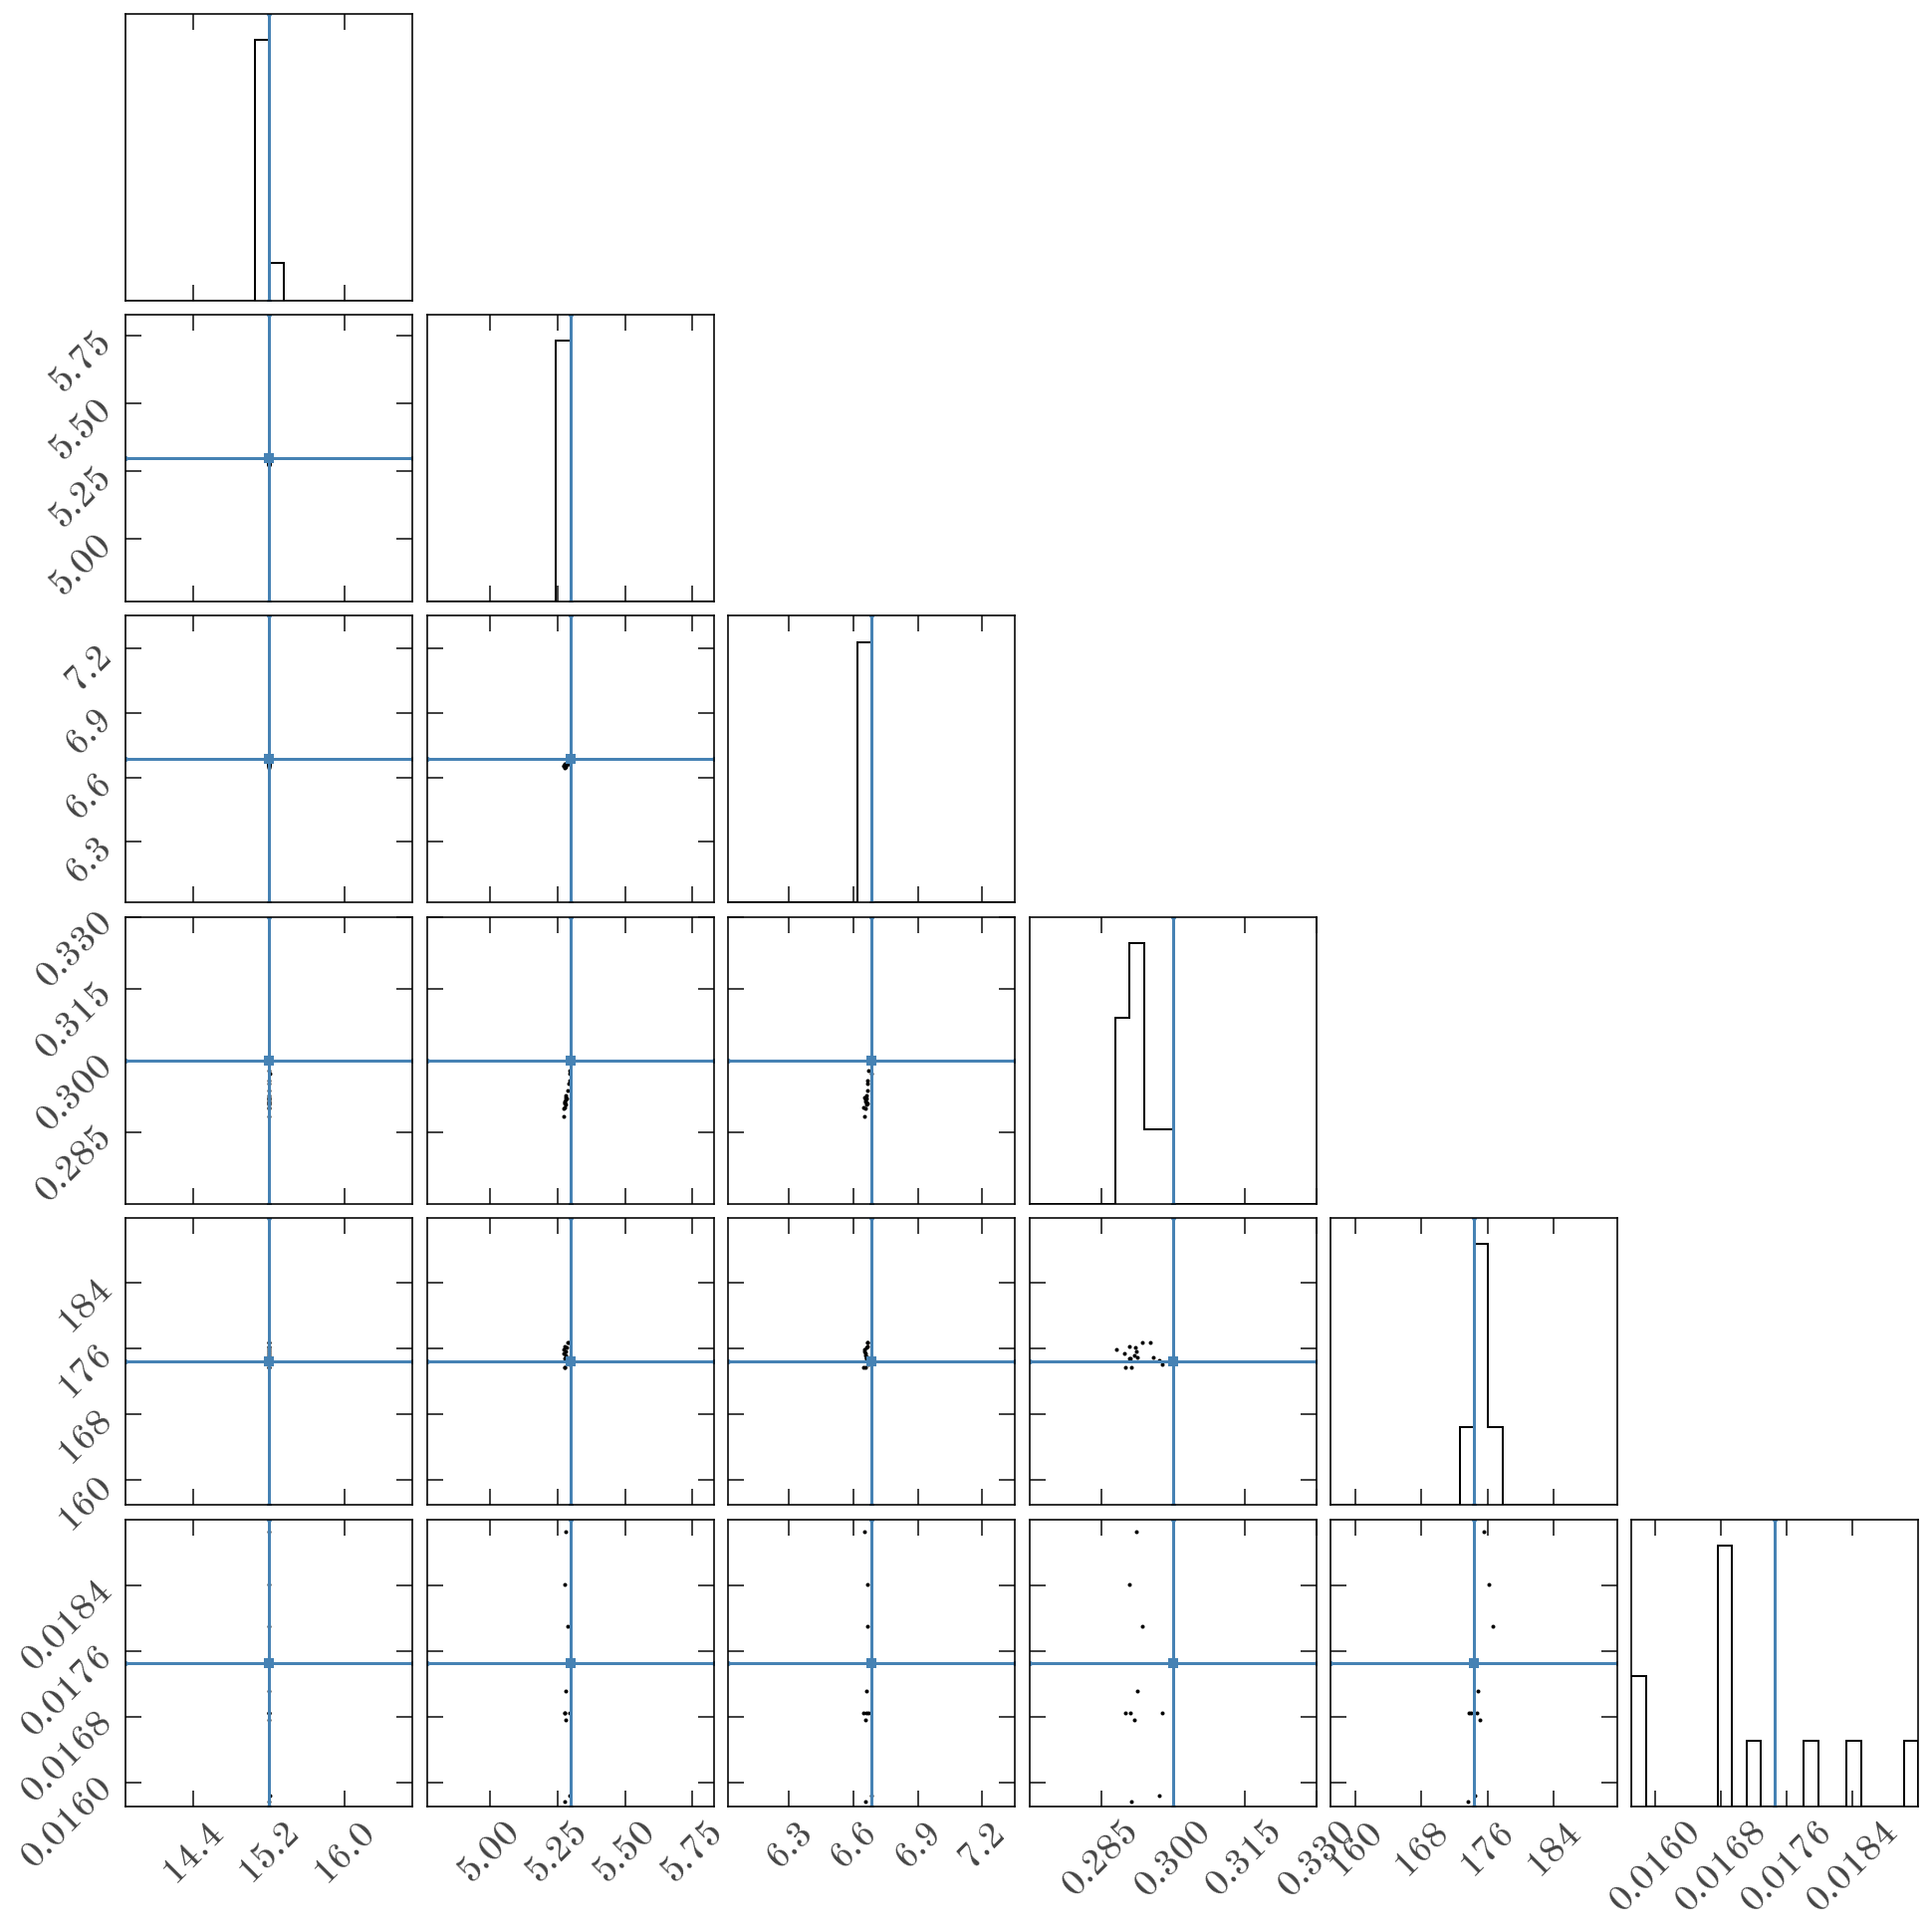

In [301]:
_ = corner.corner(bootstrap_optp, truths=p0, data_kwargs=dict(alpha=1),
                  range=np.array([0.9, 1.1])[None] * np.array(p0)[:, None],
                  plot_contours=False, plot_density=False)